In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import gridspec
import gc, h5py
from scipy import optimize

%load_ext autoreload
%autoreload 2

rc('text', usetex=False)
rc('font', family='serif', size=20)
rc('figure', figsize=(12,8))
rc('axes',linewidth=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Funzioni utili

In [45]:
def create_filter(medium,NPS): 
    '''
    medium è il segnale atteso, quello senza rumore
    NPS è il noise spectral density
    '''

    val_cal = max(medium)
    S       = np.fft.fft(medium)
    S[0]    = 0+0*1j
    OF_med  = np.fft.ifft(S*S.conjugate()/NPS).real
    K       = val_cal/np.amax(OF_med)  
    H = K*S.conjugate()/NPS   #H è la funzione di trasferimento del filtro, nel dominio delle frequenze

    return H

In [46]:
class Medium():
    '''
    Questa è la classe che permette di definire il segnale atteso dato degli eventi di rumore
    e degli eventi di segnale rumorosi.    
    '''
    
    def __init__(self, medium=None, NPS=None):
        self._medium   = medium # Pulse medium	                                           
        self._NPS      = NPS    # noise power spectrum (compunted in not normalized units) 
        return
    
    def set_NPS(self, NPS):
        # Set Noise Power Spectrum (externally computed) 
        self._NPS = NPS

    def get_NPS(self):
        return self._NPS
    
    def get_medium(self):
        return self._medium

    def set_medium(self, medium):
        self._medium = medium
        return
    
    def create_medium(self, signal_matrix, bsl=None, indexes=None):
        for _ in range(2):
            self.__do_medium(signal_matrix, bsl=bsl, indexes=indexes)
        return
    
    def __do_medium(self, signal_matrix, bsl=None, indexes=None):

        esignal_matrix = (signal_matrix.T - bsl).T if indexes is None else (signal_matrix[indexes].T - bsl[indexes]).T 
        
        S_omega = np.fft.fft(esignal_matrix, axis=1)
        S_omega[:,0] = np.zeros(esignal_matrix.shape[0])        #WHY?

        if self._medium is None:	
            S_cc = S_omega[0,:].conjugate()
        else: 
            S_cc = np.fft.fft(self._medium).conjugate()
            S_cc[0] = 0.
            								  			 

        K   = 1.                                         
        H   = K * (S_cc/self._NPS)
        OFT = np.fft.ifft(S_omega*H).real
        OFT = np.concatenate((OFT[:,int(esignal_matrix.shape[1]/2):esignal_matrix.shape[1]], OFT[:,0:int(esignal_matrix.shape[1]/2)]), axis=1)

        delay_ref = int(esignal_matrix.shape[1]/2.)
        time      = np.arange(esignal_matrix.shape[1])
        a,b       = parabolic_fit(OFT)[0:2]

        max_pos_true = -b/(2*a)
        delay        = max_pos_true - delay_ref
        del a,b, max_pos_true
        
        for i in range(esignal_matrix.shape[0]):
            esignal_matrix[i,:] = np.interp(time+delay[i],time, esignal_matrix[i,:])
        
        self._medium = np.mean(esignal_matrix,axis=0)
        
        return

In [47]:
from scipy.signal import welch

def PSD(esignal_matrix,t_sample,wind = "hann"): 
    '''
    signal_matrix una matrice di eventi di rumore (esignal_matrix) e il tempo di campionamento (t_sample), valuta la PSD
    '''
    wind     = wind
    npt      = esignal_matrix.shape[1]
        
    f, pxx = welch(esignal_matrix,fs=1./t_sample, window=wind, nperseg=npt, scaling='density', axis=1)
    mean_true_scale = np.mean(pxx, axis = 0)
        
    f = np.append( f[:-1], -1*f[1:][::-1])
    mean_true_scale = np.append( mean_true_scale[:-1],  mean_true_scale[1:][::-1] ) 
    mean_use_scale  = mean_true_scale* (1./t_sample*esignal_matrix.shape[1]/2.)    #correct?
        
    return f, mean_use_scale, mean_true_scale

In [48]:
def parabolic_fit(mat,stop=0):

    max_pos = np.argmax(mat[:,stop:-1],axis=1) + stop
    dim     = np.arange(0,mat.shape[0])
    x1 = max_pos-1
    x2 = max_pos
    x3 = max_pos+1
    y1 = mat[dim,x1]
    y2 = mat[dim,x2]
    y3 = mat[dim,x3]
    a  = (x1*(y3-y2) + x2*(y1-y3)+x3*(y2-y1) )  / ( (x1-x2)*(x1-x3)*(x2-x3)   )
    b  = (y2-y1)/(x2-x1)-a*(x1+x2)
    c  = y1 -a*x1**2 -b*x1

    return a,b,c,max_pos

In [49]:
def applyOF(esignal_matrix,H):
    
    events_OF_f = np.fft.fft(esignal_matrix, axis=1)*H
    OFF         = np.array(np.sum(np.abs(events_OF_f), axis=1)/esignal_matrix.shape[1]) 
    events_OF   = np.fft.ifft(events_OF_f).real
    events_OF   = np.concatenate((events_OF[:,int(esignal_matrix.shape[1]/2):esignal_matrix.shape[1]], events_OF[:,0:int(esignal_matrix.shape[1]/2)]),axis=1)
    a,b,c       = parabolic_fit(events_OF)[0:3]
    OFmax_pos   = np.argmax(events_OF,axis=1)
    OFdelay     = -b/(2.*a)  -esignal_matrix.shape[1]/2
    OFT         = -1.*(b**2)/(4.*a) +c
    del a,b,c, events_OF_f

    OFtest = 1. - OFT/OFF

    return OFT, OFF, OFdelay, OFtest

# Calcolo il filtro ottimo

In [50]:
from UTILS.load_data import *
noise_file, service = get_data('1jlqfOxQdq06XjZmWYrYFiQhtDJbilT8f',1000)
noise_file_2, service_2 = get_data('1RwmgPIPpVKh0tqE4fx79U7RfeJAlOJjI',1000)

In [51]:
file_sig, svc = get_data('19ApmRMhBMmQ7gT2i8akhViuKDyhP3QML',1000)

In [52]:
file_sig_2, svc_2 = get_data('12Cq--BfZONfpXNnzqw1xnwpKd4HLN5QY',1000)

In [53]:
import gzip
import io

def load_compressed_hdf5(service, file_metadata, dataset_name):
    """
    Downloads a gzipped HDF5 file from Google Drive, decompresses it, and loads it into memory.
    
    Parameters:
    service: Google Drive API service instance.
    file_metadata (dict): Metadata of the file to download (must contain 'id' and 'name').
    dataset_name (str): The name of the dataset to be extracted from the HDF5 file.
    
    Returns:
    numpy.ndarray: The data from the specified dataset in the HDF5 file.
    """
    file_id = file_metadata['id']
    file_data = drive.download_file_to_memory(service, file_id)
    
    # Decompress and load the HDF5 file
    with gzip.GzipFile(fileobj=file_data, mode='rb') as f_in:
        decompressed_data = io.BytesIO(f_in.read())
        
        with h5py.File(decompressed_data, 'r') as hdf_file:
            if dataset_name in hdf_file:
                data = np.array(hdf_file[dataset_name])
            else:
                raise KeyError(f"Dataset '{dataset_name}' not found in the HDF5 file.")
    
    return data

# Example usage:
# files, service = get_data()
# for file_metadata in files:
#     dataset = load_compressed_hdf5(service, file_metadata, 'example_data')
#     print(f"Loaded data from file: {file_metadata['name']}")

In [54]:
noise_matrix = []
for i,meta in enumerate(noise_file):
    noise_matrix.append(np.array(load_compressed_hdf5(service,meta,'example_data')))
for i,meta in enumerate(noise_file_2):
    noise_matrix.append(np.array(load_compressed_hdf5(service_2,meta,'example_data')))

Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 1

In [55]:
signal_matrix = []
for i,datum in enumerate(file_sig):
    signal_matrix.append(np.array(load_compressed_hdf5(svc,datum,'example_data')[:20000]))
for i,datum in enumerate(file_sig_2):
    signal_matrix.append(np.array(load_compressed_hdf5(svc_2,datum,'example_data')[:20000]))

Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download 1

Check for dimensions

In [ ]:
signal_matrix = np.array(signal_matrix)
noise_matrix = np.array(noise_matrix)
signal_matrix.shape == noise_matrix.shape

False

In [ ]:
preStop = 950  #E' il numero di punti della finestra di acquisizione senza il segnale.

bsl = np.mean(signal_matrix[:,0:preStop],axis=1)
bsl_noise = np.mean(noise_matrix,axis=1)

#Faccio in modo tale che i dati e il rumore partano da 0

sig_matrix = signal_matrix - np.array([bsl]).T  
noise_matrix = noise_matrix - np.array([bsl_noise]).T

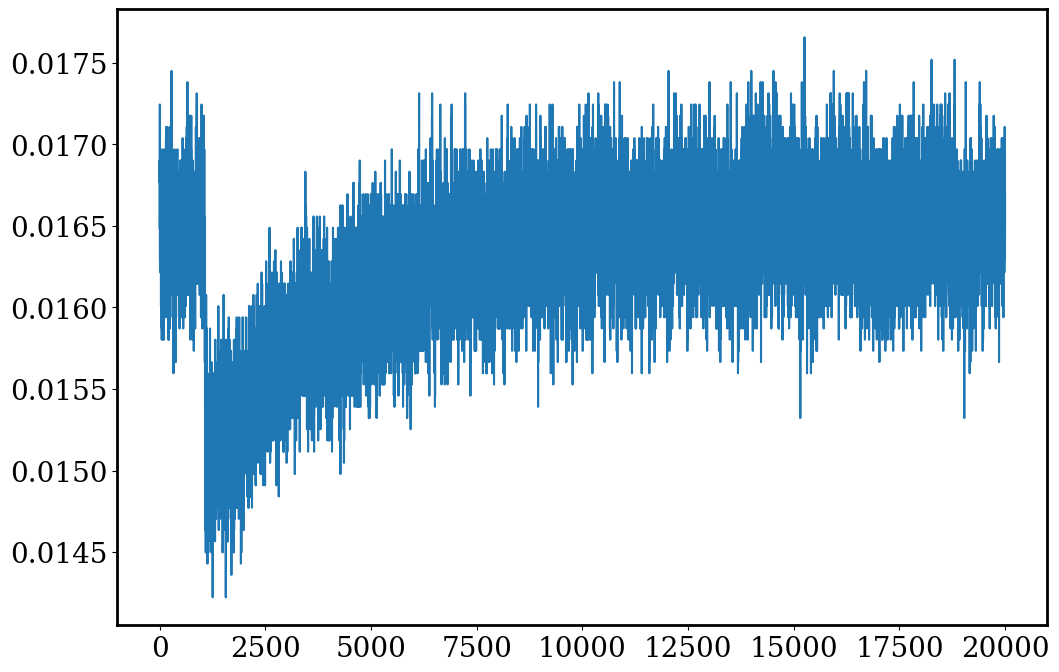

In [ ]:
plt.plot((signal_matrix[1]))

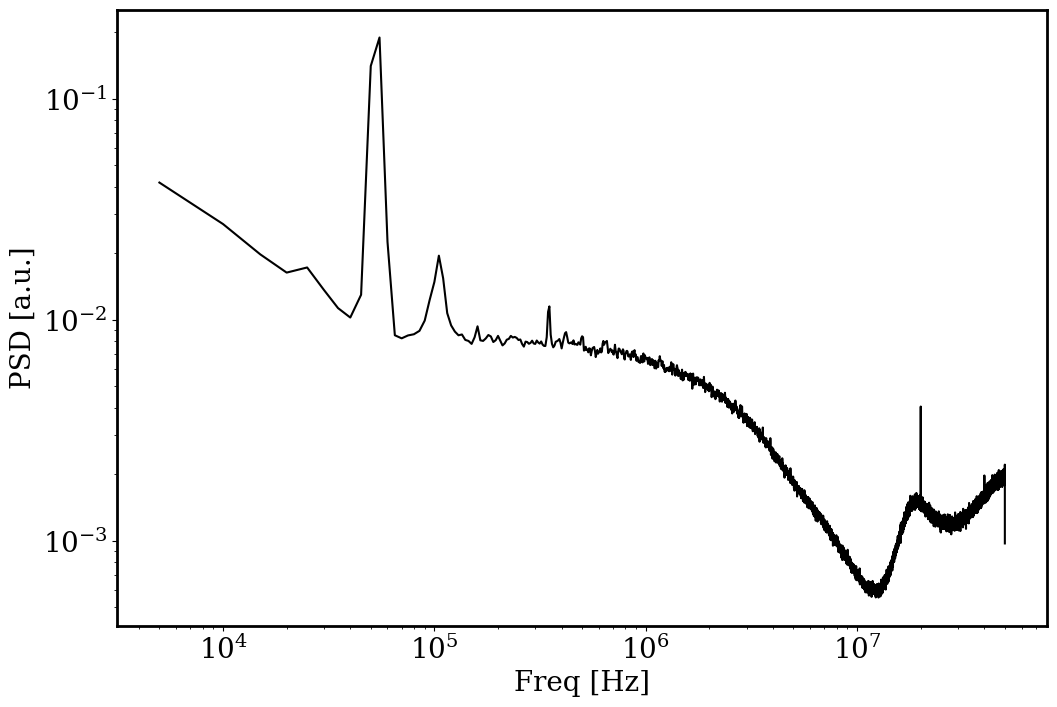

In [ ]:
# Calcolo la PSD del rumore, il primo ingrediente del filtro ottimo
t_samp = 1/1e8   #in secondi

freq, PSD_noise, _ = PSD(noise_matrix[:,:signal_matrix.shape[1]],t_samp)
#freq, PSD_sig, _ = PSD(np.array([signal_matrix[1]]),t_samp)

npt = PSD_noise.shape[0]
plt.loglog(-1*freq[npt//2:][::-1],PSD_noise[npt//2:][::-1],c='k')
plt.xlabel("Freq [Hz]")
plt.ylabel("PSD [a.u.]")
plt.show()

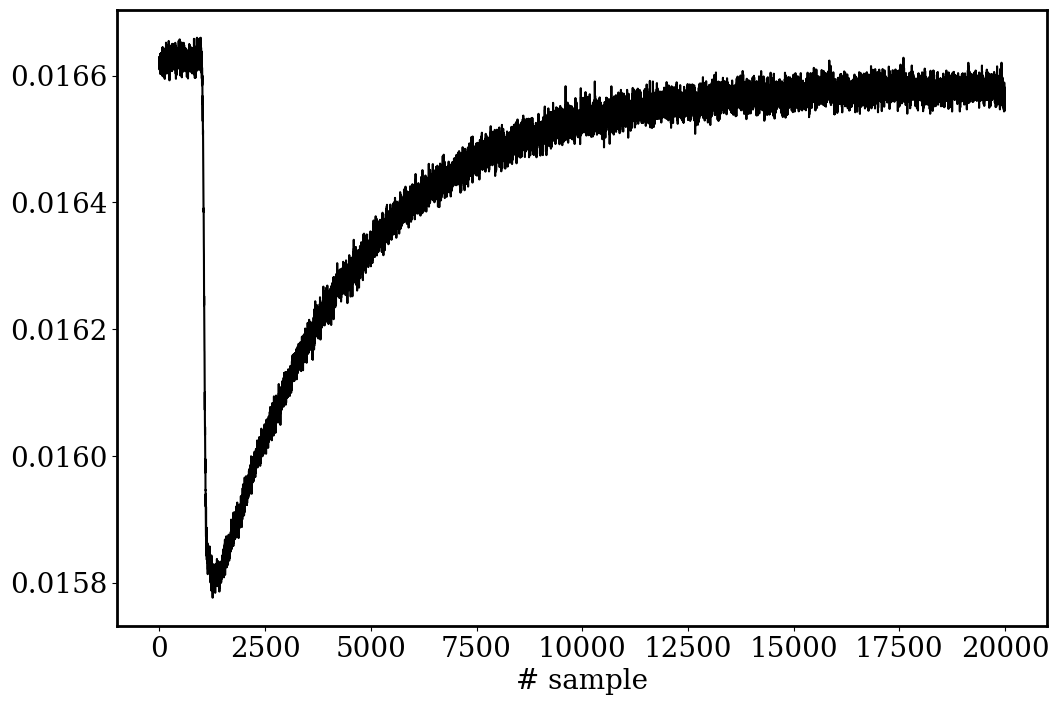

In [ ]:
# Calcolo il segnale atteso (medio), l'ultimo ingrediente per il filtro ottimo

medium = Medium(NPS = PSD_noise)
medium.create_medium(signal_matrix,np.zeros(signal_matrix.shape[0]))
medium_pulse = medium.get_medium()

plt.plot(medium_pulse,c='k')
plt.xlabel("# sample")
plt.show()

In [ ]:
# Creo il filtro H e lo applico ai dati su cui ho calcolato il medio
H = create_filter(medium_pulse,PSD_noise)

signal_matrix_filtered_f =  np.fft.fft(signal_matrix, axis=1)*H # dati filtrati dominio freq

signal_matrix_filtered_t =  np.fft.ifft(signal_matrix_filtered_f).real   #dati filtrati dominio temp
signal_matrix_filtered_t =  np.concatenate((signal_matrix_filtered_t[:,int(signal_matrix_filtered_t.shape[1]/2):signal_matrix_filtered_t.shape[1]], signal_matrix_filtered_t[:,0:int(signal_matrix_filtered_t.shape[1]/2)]),axis=1)


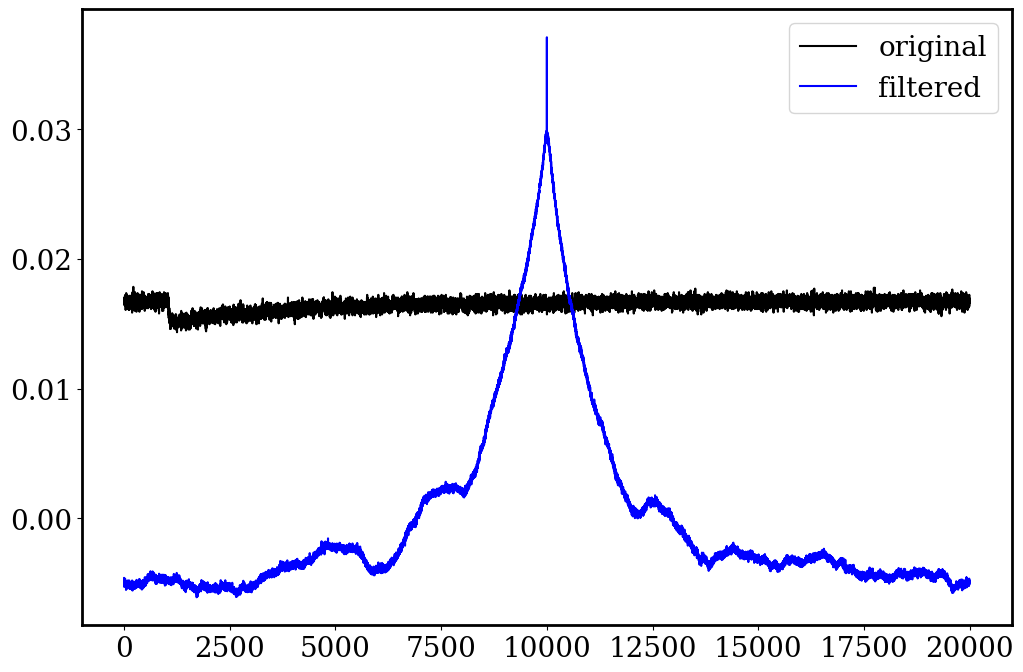

In [ ]:
#Guardo come cambiano i dati prima e dopo il filtro ottimo
nev = 0
#===================
plt.plot(signal_matrix[nev],c='k',label="original")
plt.plot(signal_matrix_filtered_t[nev],label="filtered",c='b')
plt.legend()
plt.show()

# Applico il filtro ottimo per valutare l'ampiezza dei dati

In [ ]:
'''
# Questo passaggio è da fare DOPO che si è calcolato H

signal_matrix = None  #E' la matrice dei dati su cui voglio applicare il filtro

preStop = 70  #E' il numero di punti della finestra di acquisizione senza il segnale.

bsl = np.mean(signal_matrix[:,0:preStop],axis=1)

#Faccio in modo tale che i dati e il rumore partano da 0, forse inutile(?)
signal_matrix = signal_matrix - np.array([bsl]).T
'''

"\n# Questo passaggio è da fare DOPO che si è calcolato H\n\nsignal_matrix = None  #E' la matrice dei dati su cui voglio applicare il filtro\n\npreStop = 70  #E' il numero di punti della finestra di acquisizione senza il segnale.\n\nbsl = np.mean(signal_matrix[:,0:preStop],axis=1)\n\n#Faccio in modo tale che i dati e il rumore partano da 0, forse inutile(?)\nsignal_matrix = signal_matrix - np.array([bsl]).T\n"

In [ ]:
OFT, OFF, OFdelay, OFtest = applyOF(signal_matrix,H)

# OFT è l'ampiezza del segnale, calcolata con il filtro ottimo nel dominio del tempo
# OFF è l'ampiezza del segnale, calcolata con il filtro ottimo nel dominio delle frequenze, dovrebbe essere uguale
#     (o molto simile) a OFT
# OFdelay e OFtest ignoratele.

In [21]:
print(OFT[0],OFF[0])

[0.00576042 0.00600206 0.00137265 0.00486108 0.00434825 0.00469361
 0.00492127 0.00412769 0.00423593 0.00451308 0.00475065 0.00218381
 0.00424914 0.00436032 0.0046355  0.00557098 0.00205567 0.00534944
 0.00508358 0.00169194 0.00499366 0.00205989 0.00602014 0.0045244
 0.00224699 0.00457203 0.00452364 0.00458762 0.00435749 0.00206491
 0.00515544 0.00529758 0.00500507 0.00424977 0.00568492 0.00156083
 0.00140218 0.00470752 0.00505036 0.00572006 0.00175306 0.00263794
 0.004628   0.0050927  0.00231307 0.00411723 0.00490868 0.00482183
 0.0018457  0.00508977 0.00481715 0.00551475 0.00492621 0.00180716
 0.00615034 0.00496542 0.00481839 0.00227855 0.00212007 0.00189221
 0.0052827  0.00178578 0.00524566 0.00535224 0.00495247 0.00457075
 0.00454211 0.00588575 0.00529118 0.00150868 0.00448628 0.00525159
 0.00129745 0.0050098  0.00656656 0.0019825  0.00205779 0.00468067
 0.00183214 0.0016341  0.00153243 0.00451825 0.00162109 0.00217752
 0.00204098 0.00556587 0.00164596 0.00501444 0.00501783 0.00439